## Trotterized Schwinger Model

The Schwinger Model is interesting to simulate as it is the one of the simplest gauge theores to display characteristic QCD features (confinement, Spontaneous Chiral Symmetry Breaking). The attempt at a Trotterization-based quantum simulation shown here is based on the work [here](https://quantum-journal.org/papers/q-2020-08-10-306/pdf/). 

The Lattice Hamiltonian can be expressed as:
$$H = H_E + H_I + H_M$$

Term $H_E$ relates to the energy of the electric fields in the gauge links, $H_I$ represents the minimal coupling of the Dirac and gauge fields, and $H_M$ represents the mass energy of the fermions. Bosons are associated with the lattice links while fermions are associated with the sites. The site occupation has the following interpretation: occupied even site ∼ presence of a positron, empty odd site ∼ presence of an electron. An $N$ size lattice is used to represent an $N/2$ sized physical lattice.

In [407]:
import cirq
import numpy as np
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma, show_bloqs
from typing import *
import sympy
from qualtran import SoquetT
from qualtran.symbolics import SymbolicFloat, SymbolicInt
from qualtran.bloqs.basic_gates import CNOT, Hadamard, Rz, SGate
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientUnitary
from qualtran.bloqs.qft import QFTTextBook
from qualtran.cirq_interop.t_complexity_protocol import t_complexity
from qualtran.resource_counting import BloqCount
import attrs
from math import log2

First I will define a bloq representing the hopping terms $T_r$ defined on the paper. The first step when defining such a bloq is to define the signature, essentially a list of registers that the bloq will act on. In this case the bloq represents the interaction between sites $r$ and $r+1$. The link register is also involved in the hopping terms, with links represented in a binary registed for the electric fields. The size of this electric field register depends on the chosen cutoff for their Hilbert space. Next I will define the composite bloq representing the operations performed on the qubit.

In [408]:
@attrs.frozen
class Incrementer(Bloq):  
    m: int = 4
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.m)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        eps = 1e-9 
        y = bb.add(QFTTextBook(self.m).adjoint(), q=y)

        ys = bb.split(y)
       
        for i in range(len(ys)):
            angle = 2*np.pi*2**i/(2**self.m)
            ys[i] = bb.add(Rz(angle,eps),q=ys[i])

        y = bb.join(ys)
        # QFT
        y = bb.add(QFTTextBook(self.m), q=y)

    
        return {'y': y}

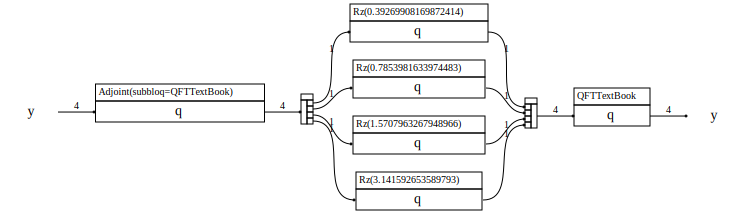

T-count:   1
Rotations: 13
Cliffords: 14



In [409]:
show_bloq(Incrementer().decompose_bloq())
print(t_complexity(Incrementer()))

In [410]:
@attrs.frozen
class Decrementer(Bloq):
    m: int = 4
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.m)
          
    def build_composite_bloq(            
            self, bb: BloqBuilder, *, y: SoquetT
    ) -> Dict[str, SoquetT]:


        y = bb.add(QFTTextBook(self.m), q=y)
        ys = bb.split(y)
        
        for i in range(len(ys)):
            angle = 2*np.pi*2**i/(2**self.m)
            ys[i] = bb.add(Rz(-angle,self.eps),q=ys[i])
             

        y = bb.join(ys)
        y = bb.add(QFTTextBook(self.m).adjoint(), q=y)
        
        return {'y': y}

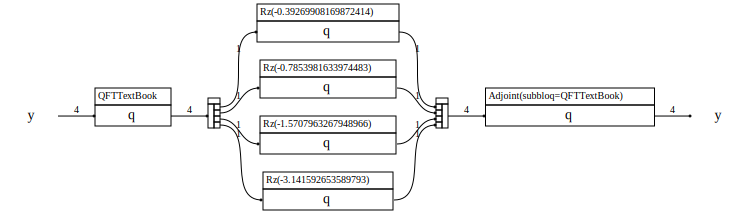

T-count:   1
Rotations: 13
Cliffords: 14



In [411]:
show_bloq(Decrementer().decompose_bloq())
print(t_complexity(Decrementer()))

In [412]:
@attrs.frozen
class HoppingTerm(Bloq): 

    n: int = 2
    m: int = 4
        
    eps: SymbolicFloat = 1e-9
    angle: SymbolicFloat = 1 

    r : int = 0
    
    @property
    def signature(self) -> Signature:
        return Signature.build(x=self.n, y=self.m)

   
    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        xs = bb.split(x)
        ys = bb.split(y)
        r = self.r
        if r == len(xs)-1:
            r_plus = 0
        else:
            r_plus = r+1
    
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])
        xs[r] = bb.add(Hadamard(),q=xs[r])
        ys[0] = bb.add(Hadamard(),q=ys[0])
        
        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])
        xs[r], xs[r_plus] = bb.add(CNOT(),ctrl=xs[r], target=xs[r_plus])

        xs[r]= bb.add(Rz(self.angle, eps=self.eps),q=xs[r]) 
        xs[r_plus]= bb.add(Rz(-self.angle, eps=self.eps),q=xs[r_plus]) 
        
        xs[r], xs[r_plus] = bb.add(CNOT(),ctrl=xs[r], target=xs[r_plus])
        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])

        ys[0]= bb.add(Hadamard(),q=ys[0])
        y =  bb.join(ys)        
        y = bb.add(Incrementer(self.m,self.eps), y=y)
        ys = bb.split(y)
        ys[0]= bb.add(Hadamard(),q=ys[0])

        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])

        xs[r]= bb.add(Rz(self.angle, eps=self.eps),q=xs[r]) 
        xs[r_plus]= bb.add(Rz(-self.angle, eps=self.eps),q=xs[r_plus]) 
        
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])
        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])

        xs[r]= bb.add(Hadamard(),q=xs[r])
        ys[0]= bb.add(Hadamard(),q=ys[0])
        xs[r]= bb.add(SGate(True),q=xs[r])
        ys[0]= bb.add(SGate(True),q=ys[0])
        xs[r]= bb.add(Hadamard(),q=xs[r])
        ys[0]= bb.add(Hadamard(),q=ys[0])

        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])

        xs[r]= bb.add(Rz(self.angle, eps=self.eps),q=xs[r]) 
        xs[r_plus]= bb.add(Rz(-self.angle, eps=self.eps),q=xs[r_plus]) 
        
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])
        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])


        ys[0]= bb.add(Hadamard(),q=ys[0])
        ys[0]= bb.add(SGate(),q=ys[0])
        y =  bb.join(ys)        
        y = bb.add(Decrementer(self.m,self.eps), y=y)
        ys = bb.split(y)
        ys[0]= bb.add(SGate(True),q=ys[0])
        ys[0]= bb.add(Hadamard(),q=ys[0])

        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])

        xs[r]= bb.add(Rz(self.angle, eps=self.eps),q=xs[r]) 
        xs[r_plus]= bb.add(Rz(-self.angle, eps=self.eps),q=xs[r_plus]) 
        
        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])
        ys[0], xs[r] = bb.add(CNOT(),ctrl=ys[0], target=xs[r])

        xs[r]= bb.add(Hadamard(),q=xs[r])
        ys[0]= bb.add(Hadamard(),q=ys[0])

        xs[r], xs[r_plus] = bb.add(CNOT(), ctrl=xs[r], target=xs[r_plus])
        xs[r]= bb.add(SGate(),q=xs[r])
        ys[0]= bb.add(SGate(),q=ys[0])
        
        return {
            'x': bb.join(xs),
            'y': bb.join(ys),
        }


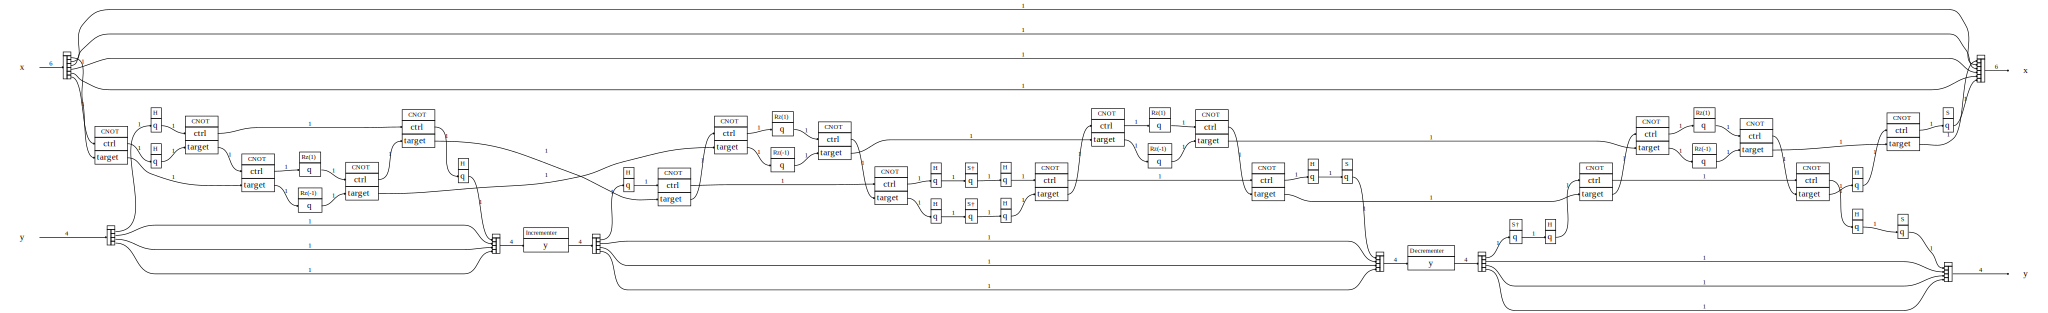

T-count:   2
Rotations: 34
Cliffords: 64



In [413]:
show_bloq(HoppingTerm(6,4,r=5).decompose_bloq())
print(t_complexity(HoppingTerm(2,4)))

Next up I will introduce the gate sequence associated with the diagonalized energy and mass terms.

In [414]:
class ElectricEnergyTerm(Bloq):    
    @property
    def signature(self) -> Signature:
        return Signature.build(y=5)
        

    eps: SymbolicFloat = 1e-9 
    angle: SymbolicFloat = 1 
    
    def build_composite_bloq(
            self, bb: BloqBuilder, *, y: SoquetT
    ) -> Dict[str, SoquetT]:
        ys = bb.split(y)

        for i in range(len(ys)):          
            for j in range(i,len(ys)):
                if i==0:
                    ys[j]= bb.add(Rz(2**j*self.angle, eps=self.eps),q=ys[j])
                else:
                    ys[i-1], ys[j] = bb.add(CNOT(),ctrl=ys[i-1], target=ys[j])
                    ys[j]= bb.add(Rz(2**j*self.angle, eps=self.eps),q=ys[j])
                    ys[i-1], ys[j] = bb.add(CNOT(),ctrl=ys[i-1], target=ys[j])
      
        return {
            'y': bb.join(ys),
        }


In [415]:
@attrs.frozen
class SimplifiedElectricEnergyTerm(Bloq): 
    m: int= 4
    eps: SymbolicFloat = 1e-9 
    angle: SymbolicFloat = 1 

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.m)
        
    
    def build_composite_bloq(
            self, bb: BloqBuilder, *, y: SoquetT
    ) -> Dict[str, SoquetT]:
        ys = bb.split(y)

        for i in range(len(ys)):          
            for j in range(i,len(ys)):
                if i==0:
                    ys[j]= bb.add(Rz(2**j*self.angle, eps=self.eps),q=ys[j])
                else:
                    ys[i-1], ys[j] = bb.add(CNOT(),ctrl=ys[i-1], target=ys[j])
                    ys[j]= bb.add(Rz((2**j+j-1)*self.angle, eps=self.eps),q=ys[j])

        ys[i-1], ys[i] = bb.add(CNOT(),ctrl=ys[i-1], target=ys[i])
        #check values of indices

        return {
            'y': bb.join(ys),
        }


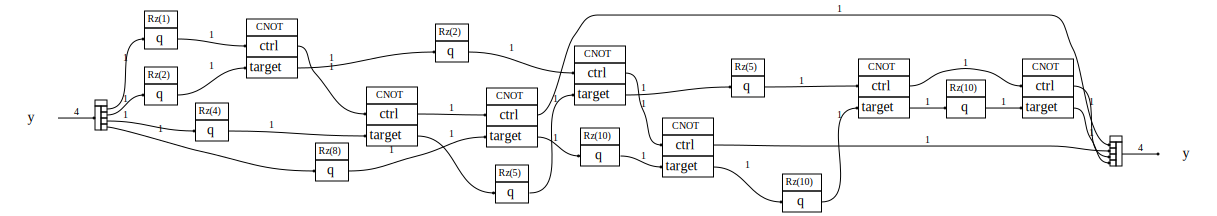

T-count:   0
Rotations: 15
Cliffords: 11



In [416]:
show_bloq(SimplifiedElectricEnergyTerm(4).decompose_bloq())
print(t_complexity(SimplifiedElectricEnergyTerm(5)))

Mass terms can be implemented with no CNOTS and single qubit gates so the paper's model considers them 'free' and this not included in their simulations and costing.

In [417]:
@attrs.frozen
class TrotterTerm(Bloq): 
    n: int = 2
    m: int = 4
    steps: int = 2
    eps: SymbolicFloat = 1e-9
    angle: SymbolicFloat = 1 
    @property
    def signature(self) -> Signature:
        return Signature.build(x=self.n, y=self.m)


    
    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:

        for i in range(self.steps):    
            y = bb.add(SimplifiedElectricEnergyTerm(self.m,self.eps), y=y)
            x, y = bb.add(HoppingTerm(self.n,self.m,self.eps), x=x, y=y)
        
        return {
            'x': x,
            'y': y,
        }

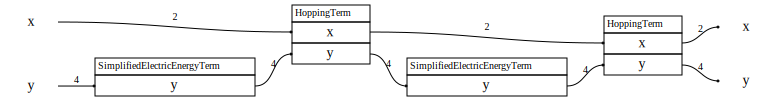

T-count:   6
Rotations: 132
Cliffords: 213



In [418]:
show_bloq(TrotterTerm(2,4,2).decompose_bloq())
print(t_complexity(TrotterTerm(2,4,3)))

## Complexity evolution with number of trotter steps (fixed rotation precision)

In [419]:
def rotation_compl(rotation_count,eps):
    t_complexity = rotation_count*1.15*log2(1/eps)
    return t_complexity

In [420]:
eps = 1e-9
compl_evol = []
step_count = []
compl_evol_incl_rot = []
for i in range(1,10):
    complexity = t_complexity(TrotterTerm(2,4,i,eps).decompose_bloq())
    t_compl = complexity.t + rotation_compl(complexity.rotations,eps)
    t_compl_2 = complexity.t_incl_rotations(eps)
    
    compl_evol.append(t_compl)
    compl_evol_incl_rot.append(t_compl_2)
    step_count.append(i)

In [421]:
import matplotlib.pyplot as plt

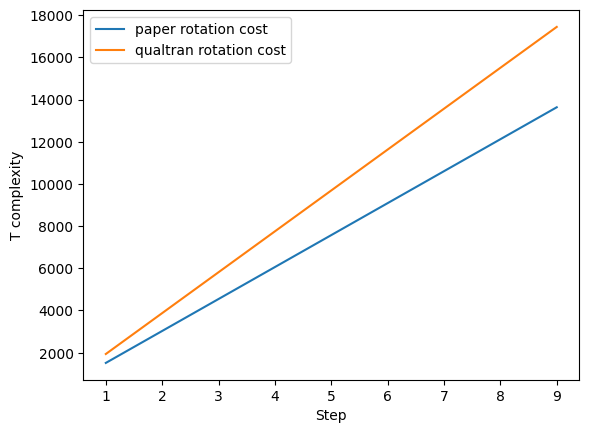

In [422]:
plt.plot(step_count,compl_evol, label="paper rotation cost")
plt.plot(step_count,compl_evol_incl_rot, label="qualtran rotation cost")
plt.xlabel("Step")
plt.ylabel("T complexity")
plt.legend()

## Complexity evolution with rotation precision (fixed number of trotter steps)

In [423]:
steps = 1
compl_evol = []
compl_evol_incl_rot = []
eps_val = []
for i in range(1,15):
    eps = 10**(-i)
    complexity = t_complexity(TrotterTerm(2,4,steps,eps).decompose_bloq())
    t_compl = complexity.t + rotation_compl(complexity.rotations,eps)
    t_compl_2 = complexity.t_incl_rotations(eps)
    compl_evol.append(t_compl)
    compl_evol_incl_rot.append(t_compl_2)
    eps_val.append(eps)

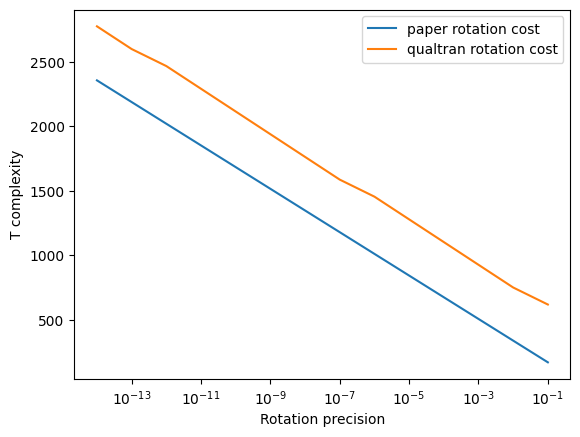

In [424]:
plt.plot(eps_val,compl_evol, label="paper rotation cost")
plt.plot(eps_val,compl_evol_incl_rot, label="qualtran rotation cost")
plt.xscale("log")
plt.xlabel("Rotation precision")
plt.ylabel("T complexity")
plt.legend()

Previous Trotter step implementation isn't really iterating over the lattice, just implementing interactions between to lattice sites. Let's implement the proper approximate time evolution operation proposed by the paper.
The Hopping term should ideally receive two qubits (representing two lattice sites) to act on, from the larger register of all lattice sites.

In [425]:
@attrs.frozen
class ApproxTimeEvolTerm(Bloq):

    N : int = 16 #lattice sites
    m: int = 4
    steps: int = 2
    angle: SymbolicFloat = 1 
    eps: SymbolicFloat = 1e-9
    
    @property
    def signature(self) -> Signature:
        return Signature.build(x=self.N, y=self.m)

    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:

        for i in range(self.steps): 
            for r in range(0,self.N):
                y = bb.add(SimplifiedElectricEnergyTerm(self.m,self.eps,self.angle/2), y=y)
                x, y = bb.add(HoppingTerm(self.N,self.m,self.eps,self.angle/2,r), x=x, y=y)

            for r in range(self.N-1,0,-1):
                x, y = bb.add(HoppingTerm(self.N,self.m,self.eps,self.angle/2,r), x=x, y=y)
                y = bb.add(SimplifiedElectricEnergyTerm(self.m,self.eps,self.angle/2), y=y)

                                
        return {
            'x': x,
            'y': y,
        }

In [426]:
show_bloq(ApproxTimeEvolTerm(16,4,1).decompose_bloq())

In [427]:
print(t_complexity(ApproxTimeEvolTerm(12,4,1)))

T-count:   46
Rotations: 1012
Cliffords: 1633



Next steps:

-Fix approx evolution term: DONE
    - What is the lattice site number and size for the electric field register that would be appropiate???

-Once this is done the cost scaling with lattice size must make sense

-Try to link cost and errors due to evolution, this would help compare with cost bounds on the paper, recheck if any other cost bounds can be compared with result, even if for a particular term

-Better understand how other gates are being taken into account by qualtran to get T counts

-Implement measurements proposed in paper

In [428]:
@attrs.frozen
class RotationCostingTest(Bloq):  
    m: int = 4
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.m)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        eps = 1e-9 
        # y = bb.add(QFTTextBook(self.m).adjoint(), q=y)

        ys = bb.split(y)
       
        for i in range(4):
            angle = 2*np.pi*2**i/(2**self.m)
            ys[i] = bb.add(Rz(angle,eps),q=ys[i])

        y = bb.join(ys)
        # QFT
        # y = bb.add(QFTTextBook(self.m), q=y)

    
        return {'y': y}

In [429]:
print(t_complexity(RotationCostingTest()))

T-count:   1
Rotations: 1
Cliffords: 2



From Qualtran documentation

In [430]:
from qualtran.resource_counting import get_cost_value, QECGatesCost

get_cost_value(RotationCostingTest(), QECGatesCost(legacy_shims=True)) #this result agrees with other method

GateCounts(t=1, toffoli=0, cswap=0, and_bloq=0, clifford=2, rotation=1, measurement=0)

In [431]:
get_cost_value(ApproxTimeEvolTerm(12,4,1), QECGatesCost(legacy_shims=True))

GateCounts(t=46, toffoli=0, cswap=0, and_bloq=0, clifford=1633, rotation=1012, measurement=0)

In [432]:
print(t_complexity(ApproxTimeEvolTerm(12,4,1)))

T-count:   46
Rotations: 1012
Cliffords: 1633

